<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#T-ALL-patients" data-toc-modified-id="T-ALL-patients-5">T-ALL patients</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#375" data-toc-modified-id="375-5.0.1">375</a></span></li><li><span><a href="#387" data-toc-modified-id="387-5.0.2">387</a></span></li><li><span><a href="#395" data-toc-modified-id="395-5.0.3">395</a></span></li></ul></li></ul></li><li><span><a href="#color-clones,-track-GLIPH" data-toc-modified-id="color-clones,-track-GLIPH-6">color clones, track GLIPH</a></span></li><li><span><a href="#this-ensures-alluvial-is-plotted-if-two-non-consecutive-samples-have-recurring-cdr3" data-toc-modified-id="this-ensures-alluvial-is-plotted-if-two-non-consecutive-samples-have-recurring-cdr3-7">this ensures alluvial is plotted if two non consecutive samples have recurring cdr3</a></span></li></ul></div>

# Dependencies

In [1]:
library(ggalluvial)
library(randomcoloR)

Loading required package: ggplot2



# Functions

In [2]:
source("/Users/anabbi/git/ped_CapTCRseq/R/clonetrack.R")

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"

gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

# Main

In [4]:
plot_clonetracks.fx

function (compldfle, plotpath, chain, countfrac, clnefrc, plottitle) 
{
    if (!(countfrac %in% c("cloneFraction", "cloneCount"))) {
        stop("Error: unknown argument ", countfrac, ". Please provide either cloneFraction or cloneCount.")
    }
    message("list of samples to track clones: ")
    mysamples <- unique(compldfle$samplename)
    print(mysamples)
    CDR3_fraction <- compldfle[, c("samplename", "nSeqCDR3", 
        "cloneFraction", "cloneCount")]
    CDR3_fraction <- CDR3_fraction[CDR3_fraction$cloneFraction > 
        clnefrc, ]
    recurring <- unique(CDR3_fraction$nSeqCDR3[duplicated(CDR3_fraction$nSeqCDR3)])
    notrecurring <- CDR3_fraction$nSeqCDR3[!CDR3_fraction$nSeqCDR3 %in% 
        recurring]
    message("Total number of recurring clonotypes: ")
    print(length(recurring))
    if (length(recurring) == 0) {
        mydummy_df <- as.data.frame(matrix(ncol = 4, nrow = length(mysamples)))
        colnames(mydummy_df) <- colnames(CDR3_fraction)
        mydummy_df$samplename <- mysamples
        mydummy_df$nSeqCDR3 <- "XXXXX"
        mydummy_df$cloneFraction <- 0
        mydummy_df$cloneCount <- 0
        CDR3_fraction <- rbind(CDR3_fraction, mydummy_df)
        recurring <- "XXXXX"
    }
    if (length(recurring) > 50) {
        recurring_df <- CDR3_fraction[CDR3_fraction$nSeqCDR3 %in% 
            recurring, ]
        recurringcdr3_ordered <- unique(recurring_df$nSeqCDR3[order(recurring_df$cloneCount, 
            decreasing = TRUE)])
        message("Total number of recurring clonotypes > 50 ")
        message("Tracking top 10 recurring clonotypes ")
        myColors <- distinctColorPalette(10)
        myColors <- c(myColors, rep("white", length(recurring) - 
            10), rep("white", length(notrecurring)))
        names(myColors) <- c(recurringcdr3_ordered, notrecurring)
        message("these are what we color: ")
        print(myColors[myColors != "white"])
    }
    else {
        myColors <- distinctColorPalette(length(recurring))
        myColors <- c(myColors, rep("white", length(notrecurring)))
        names(myColors) <- c(recurring, notrecurring)
        myColors[names(myColors) == "XXXXX"] <- "white"
        message("these are what we color: ")
        print(myColors[myColors != "white"])
    }
    for (c in recurring) {
        tmp <- CDR3_fraction[CDR3_fraction$nSeqCDR3 == c, ]
        nonexsiting <- mysamples[!mysamples %in% tmp$samplename]
        if (length(nonexsiting) > 0) {
            newentries <- data.frame(samplename = nonexsiting, 
                nSeqCDR3 = c, cloneFraction = 0, cloneCount = 0)
            CDR3_fraction <- rbind(CDR3_fraction, newentries)
        }
    }
    p <- ggplot(CDR3_fraction, aes(x = samplename, y = eval(as.name(countfrac)), 
        fill = nSeqCDR3, stratum = nSeqCDR3, alluvium = nSeqCDR3, 
        label = nSeqCDR3))
    myp <- p + geom_alluvium(decreasing = FALSE) + geom_stratum(decreasing = FALSE, 
        stat = "alluvium") + scale_fill_manual(breaks = names(myColors[myColors != 
        "white"]), values = myColors) + theme(axis.title.y = element_text(size = 50), 
        axis.title.x = element_blank(), axis.line = element_line(color = "black"), 
        axis.text = element_text(size = 50), axis.text.x = element_text(angle = 45, 
            hjust = 1), plot.title = element_text(size = 50, 
            hjust = 0.5)) + theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), panel.background = element_rect(fill = "transparent", 
            colour = NA), legend.key = element_rect(fill = "white", 
            colour = "white"), legend.position = "none", plot.margin = unit(c(0.2, 
            0, 0, 0), "cm")) + labs(y = countfrac) + labs(title = plottitle)
    pdf(paste0(plotpath, "clonetrack_", mysamples[1], chain, 
        countfrac, ".pdf"), width = 15, height = 20, useDingbats = FALSE, 
        onefile = FALSE)
    print(myp)
    dev.off()
}

In [5]:
load(file = paste0(datapath, "capTCRseq/int_load_meta.RData"))

In [6]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/NextSeq/immunarch/cloneslinks/"

In [7]:
file_list <- list.files(h4hpath, pattern = paste0("CLONES_", "TRB"), recursive = T)

In [8]:
file_list <- file_list[!grepl("_2000000", file_list)]
file_list <- file_list[!grepl("immunarch", file_list)]

In [9]:
int_load$meta[ int_load$meta$Disease_type == "T-ALL",]

Sample,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,Pass,⋯,q0_aa,q0_v,q0_j,q0_aav,q0_vj,q1_aa,q1_v,q1_j,q1_aav,q1_vj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP_324-04_cfDNA,CHP_324_04,CHP_324,X04,0.0,0.00,12,T-ALL,0,NA,⋯,2,2,2,2,2.0,1.995557,1.995557,1.995557,1.995557,1.995557
CHP_324-05_cfDNA,CHP_324_05,CHP_324,X05,0.0,0.00,12,T-ALL,0,NA,⋯,4,3,4,4,3.5,3.770348,2.579926,3.770348,3.770348,3.175137
CHP_324-05_PBMC-DNA,CHP_324_05,CHP_324,X05,0.0,0.00,12,T-ALL,0,NA,⋯,295,45,14,295,29.5,165.892624,31.274714,10.258785,165.892624,20.766750
CHP_375-01-PBMC-DNA,CHP_375_01,CHP_375,X01,1.8,0.00,14,T-ALL,1.8,NA,⋯,12,11,7,12,9.0,2.223439,1.582499,1.911728,2.223439,1.747113
CHP_375-02_cfDNA,CHP_375_02,CHP_375,X02,0.0,0.00,14,T-ALL,0,NA,⋯,17,13,9,17,11.0,6.286238,5.996816,4.215088,6.286238,5.105952
CHP_375-02-PBMC-DNA,CHP_375_02,CHP_375,X02,0.0,0.00,14,T-ALL,0,NA,⋯,647,55,14,648,34.5,510.397557,38.308064,10.809847,510.643258,24.558955
CHP_375-03_cfDNA,CHP_375_03,CHP_375,X03,0.0,0.00,14,T-ALL,0,NA,⋯,17,13,9,17,11.0,6.336502,6.283103,3.798558,6.336502,5.040831
CHP_375-04_cfDNA,CHP_375_04,CHP_375,X04,0.6,0.00,14,T-ALL,0.6,NA,⋯,33,21,9,33,15.0,19.821220,13.584535,6.235886,19.821220,9.910210
CHP_375-05_cfDNA,CHP_375_05,CHP_375,X05,0.5,0.00,14,T-ALL,0.5,NA,⋯,66,32,13,66,22.5,30.624927,16.204228,9.052041,30.624927,12.628134


# T-ALL patients

### 375

In [47]:
chp375 <- file_list[grepl("375", file_list)]

In [48]:
chp375

[1] "CLONES_TRBCHP_375-01-PBMC-DNA.txt" "CLONES_TRBCHP_375-02_cfDNA.txt"   
[3] "CLONES_TRBCHP_375-02-PBMC-DNA.txt" "CLONES_TRBCHP_375-03_cfDNA.txt"   
[5] "CLONES_TRBCHP_375-04_cfDNA.txt"    "CLONES_TRBCHP_375-05_cfDNA.txt"   
[7] "CLONES_TRBCHP_375-05_PBMC_DNA.txt"

In [49]:
cdr3df <- cdr3_dataframe.fx(h4hpath, "TRB", chp375, "inframe")

my files:



[1] "CLONES_TRBCHP_375-01-PBMC-DNA.txt" "CLONES_TRBCHP_375-02_cfDNA.txt"   
[3] "CLONES_TRBCHP_375-02-PBMC-DNA.txt" "CLONES_TRBCHP_375-03_cfDNA.txt"   
[5] "CLONES_TRBCHP_375-04_cfDNA.txt"    "CLONES_TRBCHP_375-05_cfDNA.txt"   
[7] "CLONES_TRBCHP_375-05_PBMC_DNA.txt"


Total recovered clonotypes:



[1] 1168


Total out-of-frame clonotypes:



[1] 252


Total clonotypes with stop codon:



[1] 28


Total productive clonotypes:



[1] 888


Output contains in_frame clonotypes only



In [54]:
compldfle <- cdr3df

In [56]:
message("list of samples to track clones: ")
    mysamples <- unique(compldfle$samplename)
    print(mysamples)
    CDR3_fraction <- compldfle[, c("samplename", "nSeqCDR3", 
        "cloneFraction", "cloneCount")]
    CDR3_fraction <- CDR3_fraction[CDR3_fraction$cloneFraction > 
        0, ]
    recurring <- unique(CDR3_fraction$nSeqCDR3[duplicated(CDR3_fraction$nSeqCDR3)])
    notrecurring <- CDR3_fraction$nSeqCDR3[!CDR3_fraction$nSeqCDR3 %in% 
        recurring]
    message("Total number of recurring clonotypes: ")
    print(length(recurring))
    if (length(recurring) == 0) {
        mydummy_df <- as.data.frame(matrix(ncol = 4, nrow = length(mysamples)))
        colnames(mydummy_df) <- colnames(CDR3_fraction)
        mydummy_df$samplename <- mysamples
        mydummy_df$nSeqCDR3 <- "XXXXX"
        mydummy_df$cloneFraction <- 0
        mydummy_df$cloneCount <- 0
        CDR3_fraction <- rbind(CDR3_fraction, mydummy_df)
        recurring <- "XXXXX"
    }
    if (length(recurring) > 50) {
        recurring_df <- CDR3_fraction[CDR3_fraction$nSeqCDR3 %in% 
            recurring, ]
        recurringcdr3_ordered <- unique(recurring_df$nSeqCDR3[order(recurring_df$cloneCount, 
            decreasing = TRUE)])
        message("Total number of recurring clonotypes > 50 ")
        message("Tracking top 10 recurring clonotypes ")
        myColors <- distinctColorPalette(10)
        myColors <- c(myColors, rep("white", length(recurring) - 
            10), rep("white", length(notrecurring)))
        names(myColors) <- c(recurringcdr3_ordered, notrecurring)
        message("these are what we color: ")
        print(myColors[myColors != "white"])
    } else {
        myColors <- distinctColorPalette(length(recurring))
        myColors <- c(myColors, rep("white", length(notrecurring)))
        names(myColors) <- c(recurring, notrecurring)
        myColors[names(myColors) == "XXXXX"] <- "white"
        message("these are what we color: ")
        print(myColors[myColors != "white"])
    }
    for (c in recurring) {
        tmp <- CDR3_fraction[CDR3_fraction$nSeqCDR3 == c, ]
        nonexsiting <- mysamples[!mysamples %in% tmp$samplename]
        if (length(nonexsiting) > 0) {
            newentries <- data.frame(samplename = nonexsiting, 
                nSeqCDR3 = c, cloneFraction = 0, cloneCount = 0)
            CDR3_fraction <- rbind(CDR3_fraction, newentries)
        }
    }
    

list of samples to track clones: 



[1] "CHP_375-01-PBMC-DNA" "CHP_375-02_cfDNA"    "CHP_375-02-PBMC-DNA"
[4] "CHP_375-03_cfDNA"    "CHP_375-04_cfDNA"    "CHP_375-05_cfDNA"   
[7] "CHP_375-05_PBMC_DNA"


Total number of recurring clonotypes: 



[1] 7


these are what we color: 



TGTGCCAGCAGTTACGAGTCTCTTGGGGAACGACTCTATGGCTACACCTTC 
                                          "#D5D16C" 
      TGTGCCAGCAGTGAACTAGCGGGGGGGTACAATGAGCAGTTCTTC 
                                          "#D67072" 
TGTGCCAGCAGTCCCGAGTTTCAGGGCGTCTCTGGAAACACCATATATTTT 
                                          "#B09ED4" 
   TGTGCCAGCAGCTCGGGACTAGCGGGGGGGCAAGAGACCCAGTACTTC 
                                          "#85E275" 
         TGTGCCAGCAGCTTTGCCCCAGGGGTAAGCGAGCAGTACTTC 
                                          "#D3CDC1" 
            TGCAGTGCGTCCCAGGAGAGAGCCTATGGCTACACCTTC 
                                          "#7FD6C8" 
      TGTGCCAGCAGCCACAGGGGGTGGGTCAATCAGCCCCAGCATTTT 
                                          "#BA57D2" 


In [78]:
head(CDR3_fraction)

,samplename,nSeqCDR3,cloneFraction,cloneCount
,<chr>,<chr>,<dbl>,<dbl>
3,CHP_375-01-PBMC-DNA,TGTGCCAGCAGTGAACTAGCGGGGGGGTACAATGAGCAGTTCTTC,0.2162162,8
5,CHP_375-01-PBMC-DNA,TGTGCCAGTAGTCTTCACGGGGACAGGGGATTTTATGGCTACACCTTC,0.1351351,5
6,CHP_375-01-PBMC-DNA,TGTGCCAGCAGTGACTCTAGCGGGGGGGCCAATGAGCAGTTCTTC,0.1351351,5
7,CHP_375-01-PBMC-DNA,TGTGCCAGCAGCCACAGGGGGTGGGTCAATCAGCCCCAGCATTTT,0.1351351,5
8,CHP_375-01-PBMC-DNA,TGTGCCAGCAGCTTAGGGGGGTACCAAGAGACCCAGTACTTC,0.1351351,5
9,CHP_375-01-PBMC-DNA,TGTGCCAGCAATCCGGGGCCGGGGGTTAACACTGAAGCTTTCTTT,0.1081081,4


In [79]:
p <- ggplot(CDR3_fraction, aes(x = samplename, y = cloneCount, 
        fill = nSeqCDR3, stratum = nSeqCDR3, alluvium = nSeqCDR3, 
        label = nSeqCDR3))
    myp <- p + geom_alluvium(decreasing = FALSE) + geom_stratum(decreasing = FALSE, 
        stat = "alluvium") + scale_fill_manual(breaks = names(myColors[myColors != 
        "white"]), values = myColors) + theme(axis.title.y = element_text(size = 50), 
        axis.title.x = element_blank(), axis.line = element_line(color = "black"), 
        axis.text = element_text(size = 50), axis.text.x = element_text(angle = 45, 
            hjust = 1), plot.title = element_text(size = 50, 
            hjust = 0.5)) + theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), panel.background = element_rect(fill = "transparent", 
            colour = NA), legend.key = element_rect(fill = "white", 
            colour = "white"), legend.position = "none", plot.margin = unit(c(0.2, 
            0, 0, 0), "cm")) 

In [50]:
plot_clonetracks.fx(cdr3df, plotpath, "TRB", "cloneFraction", 0, "T-ALL (PBMC)")

list of samples to track clones: 



[1] "CHP_375-01-PBMC-DNA" "CHP_375-02_cfDNA"    "CHP_375-02-PBMC-DNA"
[4] "CHP_375-03_cfDNA"    "CHP_375-04_cfDNA"    "CHP_375-05_cfDNA"   
[7] "CHP_375-05_PBMC_DNA"


Total number of recurring clonotypes: 



[1] 7


these are what we color: 



TGTGCCAGCAGTTACGAGTCTCTTGGGGAACGACTCTATGGCTACACCTTC 
                                          "#ACCFD2" 
      TGTGCCAGCAGTGAACTAGCGGGGGGGTACAATGAGCAGTTCTTC 
                                          "#8BDFAA" 
TGTGCCAGCAGTCCCGAGTTTCAGGGCGTCTCTGGAAACACCATATATTTT 
                                          "#DBAD78" 
   TGTGCCAGCAGCTCGGGACTAGCGGGGGGGCAAGAGACCCAGTACTTC 
                                          "#DA6794" 
         TGTGCCAGCAGCTTTGCCCCAGGGGTAAGCGAGCAGTACTTC 
                                          "#B454D7" 
            TGCAGTGCGTCCCAGGAGAGAGCCTATGGCTACACCTTC 
                                          "#B39CD3" 
      TGTGCCAGCAGCCACAGGGGGTGGGTCAATCAGCCCCAGCATTTT 
                                          "#B5E25E" 


pdf 
  2

In [15]:
cfdnafile <- file_list[grepl("375", file_list)]

In [16]:
cfdnafile <- cfdnafile[grepl("cfDNA", cfdnafile)]

In [17]:
cfdnafile

[1] "batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_375-02_cfDNA.txt"
[2] "batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_375-04_cfDNA.txt"
[3] "batch13_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_375-03_cfDNA.txt"
[4] "batch13_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_375-05_cfDNA.txt"

In [18]:
cdr3df <- cdr3_dataframe.fx(h4hpath, "TRB", cfdnafile, "inframe")

my files:



[1] "batch10_cfDNA_13Jul2020/mixcr/clones/CLONES_TRBCHP_375-02_cfDNA.txt"
[2] "batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_375-04_cfDNA.txt"
[3] "batch13_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_375-03_cfDNA.txt"
[4] "batch13_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_375-05_cfDNA.txt"


Total recovered clonotypes:



[1] 138


Total out-of-frame clonotypes:



[1] 33


Total clonotypes with stop codon:



[1] 4


Total productive clonotypes:



[1] 101


Output contains in_frame clonotypes only



In [19]:
cdr3df$samplename <- gsub("_cfDNA.txt", "", cdr3df$samplename)

In [20]:
plot_clonetracks.fx(cdr3df, plotpath, "TRB", "cloneFraction", 0, "T-ALL (cfDNA)")

list of samples to track clones: 



[1] "CHP_375-02" "CHP_375-04" "CHP_375-03" "CHP_375-05"


Total number of recurring clonotypes: 



[1] 0


these are what we color: 



named character(0)


pdf 
  2

### 387

In [21]:
pbmcfile <- file_list[grepl("387", file_list)]

In [22]:
pbmcfile <- pbmcfile[grepl("PBMC", pbmcfile)]

In [23]:
pbmcfile

[1] "batch11_23Apr2020/mixcr/clones/CLONES_TRBCHP_387-02_PBMC_DNA.txt"
[2] "batch11_23Apr2020/mixcr/clones/CLONES_TRBCHP_387-03_PBMC_DNA.txt"
[3] "batch8_14Jan2020/mixcr/clones/CLONES_TRBCHP_387-01-PBMC-DNA.txt"

In [24]:
cdr3df <- cdr3_dataframe.fx(h4hpath, "TRB", pbmcfile, "inframe")

my files:



[1] "batch11_23Apr2020/mixcr/clones/CLONES_TRBCHP_387-02_PBMC_DNA.txt"
[2] "batch11_23Apr2020/mixcr/clones/CLONES_TRBCHP_387-03_PBMC_DNA.txt"
[3] "batch8_14Jan2020/mixcr/clones/CLONES_TRBCHP_387-01-PBMC-DNA.txt" 


Total recovered clonotypes:



[1] 1323


Total out-of-frame clonotypes:



[1] 334


Total clonotypes with stop codon:



[1] 26


Total productive clonotypes:



[1] 963


Output contains in_frame clonotypes only



In [25]:
cdr3df$samplename <- gsub("_PBMC_DNA.txt", "", cdr3df$samplename)
cdr3df$samplename <- gsub("-PBMC-DNA.txt", "", cdr3df$samplename)

In [26]:
plot_clonetracks.fx(cdr3df, plotpath, "TRB", "cloneFraction", 0, "T-ALL (PBMC)")

list of samples to track clones: 



[1] "CHP_387-02" "CHP_387-03" "CHP_387-01"


Total number of recurring clonotypes: 



[1] 11


these are what we color: 



            TGTGCCAGCAGCCGCAATACCCAGCCCCAGGTGGGACGGTCCAATGAGCAGTTCTTC 
                                                            "#87E3C5" 
                           TGTGCCAGCAGGTCTAGCGGTTCCTACAATGAGCAGTTCTTC 
                                                            "#D86CD2" 
                                 TGTGCCAGCAGCTTAGTAAGGGGTGAAGCTTTCTTT 
                                                            "#8588D3" 
               TGTGCCAGCAGCTTAATCGTCCGGGACAGAGCCATGAACACTGAAGCTTTCTTT 
                                                            "#D78A5C" 
                        TGTGCCAGCAGCGCAGGGGGGCAGGTCAATCAGCCCCAGCATTTT 
                                                            "#CDD557" 
                           TGTGCCAGCAGTTACAGCTCTGGGGCCAACGTCCTGACTTTC 
                                                            "#79DF70" 
                           TGTGCCAGCAGCCCGACAGGGGTATACGAAAAACTGTTTTTT 
                                                            "#D6D6B5" 
      

pdf 
  2

In [27]:
cfdnafile <- file_list[grepl("387", file_list)]

In [28]:
cfdnafile <- cfdnafile[grepl("cfDNA", cfdnafile)]

In [29]:
cfdnafile

[1] "batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_387-03_cfDNA.txt"            
[2] "batch7_cfDNA_29Jun2020/mixcr/clones/CLONES_TRBCHP_387-01_cfDNA.txt"             
[3] "remaining_batch_2_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_387-02_cfDNA.txt"

In [30]:
cdr3df <- cdr3_dataframe.fx(h4hpath, "TRB", cfdnafile, "inframe")

my files:



[1] "batch11_cfDNA_11Sep2020/mixcr/clones/CLONES_TRBCHP_387-03_cfDNA.txt"            
[2] "batch7_cfDNA_29Jun2020/mixcr/clones/CLONES_TRBCHP_387-01_cfDNA.txt"             
[3] "remaining_batch_2_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_387-02_cfDNA.txt"


Total recovered clonotypes:



[1] 26


Total out-of-frame clonotypes:



[1] 6


Total clonotypes with stop codon:



[1] 1


Total productive clonotypes:



[1] 19


Output contains in_frame clonotypes only



In [31]:
cdr3df$samplename <- gsub("_cfDNA.txt", "", cdr3df$samplename)

In [32]:
plot_clonetracks.fx(cdr3df, plotpath, "TRB", "cloneFraction", 0, "T-ALL (cfDNA)")

list of samples to track clones: 



[1] "CHP_387-03" "CHP_387-01" "CHP_387-02"


Total number of recurring clonotypes: 



[1] 0


these are what we color: 



named character(0)


pdf 
  2

### 395

In [33]:
cfdnafile <- file_list[grepl("395", file_list)]

In [34]:
cfdnafile

[1] "batch7_cfDNA_29Jun2020/mixcr/clones/CLONES_TRBCHP_395-01_cfDNA.txt"
[2] "priority_pool2/mixcr/clones/CLONES_TRBCHP_395-02_cfDNA.txt"

In [40]:
cdr3df <- cdr3_dataframe.fx(h4hpath, "TRB", cfdnafile, "inframe")

ERROR: Error in cdr3_dataframe.fx(h4hpath, "TRB", cfdnafile, "inframe"): object 'cfdnafile' not found


In [36]:
cdr3df$samplename <- gsub("_cfDNA.txt", "", cdr3df$samplename)

In [37]:
plot_clonetracks.fx(cdr3df, plotpath, "TRB", "cloneFraction", 0, "T-ALL (cfDNA)")

list of samples to track clones: 



[1] "CHP_395-01" "CHP_395-02"


Total number of recurring clonotypes: 



[1] 1


these are what we color: 



TGCAGTGCTAGAGACAGGGGCCTGAACACTGAAGCTTTCTTT 
                                 "#BDB3B1" 


pdf 
  2

# color clones, track GLIPH

In [4]:
gliph <- read.table(file = "~/Downloads/demo_cluster.txt", sep = ",", header = T)

In [5]:
head(gliph[,1:20])

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq,HLA.A
,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,SVAL,4.4e-19,10,16,5.7e-13,4e-04,0.001,0.45,0.037,8.6e-05,motif-SVAL,CASSVaLASGANVLTF,CASSVALASGANVLTF,TRBV9,TRBJ2-6,CAGAGGGGFKTIF,02/0152:MegaIL2,2,-
2,1,SVAL,4.4e-19,10,16,5.7e-13,4e-04,0.001,0.45,0.037,8.6e-05,motif-SVAL,CASSValsNYGYTF,CASSVALSNYGYTF,TRBV9,TRBJ1-2,CAVVASGGSYIPTF,01/1013:MtbLys,2,-
3,1,SVAL,4.4e-19,10,16,5.7e-13,4e-04,0.001,0.45,0.037,8.6e-05,motif-SVAL,CASSValyGQsvTF,CASSVALYGQSVTF,TRBV9,TRBJ1-2,CAAFSGTYKYIF,09/0328:MtbLys,1,-
4,1,SVAL,4.4e-19,10,16,5.7e-13,4e-04,0.001,0.45,0.037,8.6e-05,motif-SVAL,CASSValLAGTQYF,CASSVALLAGTQYF,TRBV9,TRBJ2-3,CAGPGGTSYGKLTF,09/0671:MtbLys,1,-
5,1,SVAL,4.4e-19,10,16,5.7e-13,4e-04,0.001,0.45,0.037,8.6e-05,motif-SVAL,CASSValgAGGGYTF,CASSVALGAGGGYTF,TRBV9,TRBJ1-2,CAGPSGGSYIPTF,09/0328:MtbLys,1,-
6,1,SVAL,4.4e-19,10,16,5.7e-13,4e-04,0.001,0.45,0.037,8.6e-05,motif-SVAL,CASSVallgETQYF,CASSVALLGETQYF,TRBV9,TRBJ2-5,CAGAPTGNQFYF,09/0772:MtbLys,1,-


In [6]:
gliphdf <- gliph[1:50,]

In [9]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [10]:
#get cdr3 occuring in more than one sample
tmp <- gliphdf %>% 
group_by(TcRb) %>%
filter(n() > 1) %>% 
group_by(TcRb, Sample) %>% 
filter(n() == 1)

In [11]:
tmp

index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,⋯,HLA.B,HLA.C,HLA.DPA1,HLA.DPB1,HLA.DQA1,HLA.DQB1,HLA.DRB1,HLA.DRB3,HLA.DRB4,HLA.DRB5
<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.45,0.037,⋯,-,-,DPA1*02:01/DPA1*02:02,DPB1*01:01/DPB1*01:01,DQA1*01:02/DQA1*05:05,DQB1*03:01/DQB1*06:02!,DRB1*03:01/DRB1*15:03!,DRB3*02:02,-,DRB5*01:01!
1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.45,0.037,⋯,-,-,DPA1*01:03/DPA1*04:01,DPB1*02:01/DPB1*105:01,DQA1*01:02/DQA1*02:01,DQB1*03:03/DQB1*06:02!,DRB1*07:01/DRB1*15:03!,-,DRB4*01:03,DRB5*01:01!
7,QFIG,3.1e-08,3,3,1.0e-08,0.0370,0.001,0.21,0.220,⋯,-,-,DPA1*02:01/DPA1*02:02,DPB1*01:01/DPB1*13:01,DQA1*01:02/DQA1*05:02!,DQB1*03:19/DQB1*06:02,DRB1*11:01!/DRB1*15:03,DRB3*02:02!/DRB3*02:02!,-,-
7,QFIG,3.1e-08,3,3,1.0e-08,0.0370,0.001,0.21,0.220,⋯,-,-,DPA1*02:01/DPA1*02:02,DPB1*01:01/DPB1*13:01,DQA1*01:02/DQA1*05:02!,DQB1*03:19/DQB1*06:02,DRB1*11:01!/DRB1*15:03,DRB3*02:02!/DRB3*02:02!,-,-


In [12]:
gliphdf[ gliphdf$TcRb == "CASSVALLGETQYF","Sample"]

[1] "09/0772:MtbLys" "09/0531:MtbLys"

In [13]:
recurring_cdr3 <- unique(gliphdf$TcRb[duplicated(gliphdf$TcRb)])
notrecurring_cdr3 <- gliphdf$TcRb[!gliphdf$TcRb %in% recurring_cdr3]

message("Total number of recurring clonotypes: ")
print(length(recurring_cdr3))

Total number of recurring clonotypes: 



[1] 6


In [14]:
recurring_cdr3

[1] "CASSVALLGETQYF"     "CASSPGTESNQPQHF"    "CASSLGTESNQPQHF"   
[4] "CASSSGTESNQPQHF"    "CASSFGTESNQPQHF"    "CASSQFIGDTDQSDTQYF"

In [15]:
 #   if (length(recurring_cdr3) == 0) {
 #       mydummy_df <- as.data.frame(matrix(ncol = ncol(gliphdf), nrow = length(mysamples)))
 #       colnames(mydummy_df) <- colnames(gliphdf)
  #      mydummy_df$Sample <- mysamples
   #     mydummy_df$TcRb <- "XXXXX"
    #    mydummy_df$Freq <- 0
 #       gliphdf <- rbind(gliphdf, mydummy_df)
 #       recurring_cdr3 <- "XXXXX"
  #  }

In [16]:

    myColors <- distinctColorPalette(length(recurring_cdr3))
    myColors <- c(myColors, rep("white", length(notrecurring_cdr3)))
    names(myColors) <- c(recurring_cdr3, notrecurring_cdr3)
  #  myColors[names(myColors) == "XXXXX"] <- "white"
    message("these are what we color: ")
    print(myColors[myColors != "white"])
    

these are what we color: 



    CASSVALLGETQYF    CASSPGTESNQPQHF    CASSLGTESNQPQHF    CASSSGTESNQPQHF 
         "#DDC47C"          "#A2DACC"          "#B4AAD5"          "#BE5ED5" 
   CASSFGTESNQPQHF CASSQFIGDTDQSDTQYF 
         "#E27682"          "#A7E46C" 


In [17]:
alluvialdf <- gliphdf#[, c("Sample", "TcRb", "Freq")]

In [18]:
alluvialdf$xx <- paste(alluvialdf$pattern, alluvialdf$TcRb, sep = ":")

In [63]:
alluvialdf$p_sample <- paste(alluvialdf$pattern, alluvialdf$Sample, sep = "_")

In [64]:
alluvialdf$p_sample[duplicated(alluvialdf$p_sample)]

[1] "SVAL_09/0328:MtbLys"      "SVAL_01/0943:MtbLys"     
 [3] "SVAL_09/0328:MtbLys"      "SVAL_09/0671:MtbLys"     
 [5] "SVAL_09/0328:MtbLys"      "SVAL_09/0671:MtbLys"     
 [7] "GLVL_09/0717:MtbLys"      "TESN_03/0480:MtbLys"     
 [9] "TESN_03/0480:MtbLys"      "TESN_03/0480:MtbLys"     
[11] "TESN_03/0480:MtbLys"      "EEPR_09/0730:MtbLys"     
[13] "EEPR_03/0493:MtbLys"      "EEPR_03/0493:MtbLys"     
[15] "SQFL_03/0302:MtbLys"      "S%GTESNQP_03/0480:MtbLys"
[17] "S%GTESNQP_03/0480:MtbLys"

In [19]:
alluvialdf[alluvialdf$xx == "SVAL:CASSVALLGETQYF",1:20]

,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq,HLA.A
,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
6,1,SVAL,4.4e-19,10,16,5.7e-13,4e-04,0.001,0.45,0.037,8.6e-05,motif-SVAL,CASSVallgETQYF,CASSVALLGETQYF,TRBV9,TRBJ2-5,CAGAPTGNQFYF,09/0772:MtbLys,1,-
7,1,SVAL,4.4e-19,10,16,5.7e-13,4e-04,0.001,0.45,0.037,8.6e-05,motif-SVAL,CASSVallgETQYF,CASSVALLGETQYF,TRBV9,TRBJ2-5,CAGTGGTSYGKLTF,09/0531:MtbLys,1,-


In [65]:
# has to be unique
#alluvialdf <- alluvialdf[ !duplicated(alluvialdf$xx),]

In [20]:
alluvialdf <- alluvialdf[, c("xx", colnames(alluvialdf)[1:19])]

In [22]:
#recurrent motifs
mytab <- as.data.frame(table(alluvialdf$pattern), stringsAsFactors = F)

recur_motifs <- mytab$Var1[ mytab$Freq > 1]

In [23]:
mytab

Var1,Freq
<chr>,<int>
EEPR,5
GLVL,8
QFIG,3
S%GTESNQP,5
SQFL,4
SVAL,17
TESN,8


In [24]:
recur_motifs

[1] "EEPR"      "GLVL"      "QFIG"      "S%GTESNQP" "SQFL"      "SVAL"     
[7] "TESN"

In [25]:
motifColors <- distinctColorPalette(length(recur_motifs))

In [26]:
head(motifColors)

[1] "#B2E56C" "#DFB872" "#CDCBCD" "#9898D9" "#E1759E" "#BF55DB"

In [27]:
recurringmotifColors <- vector()

for(i in 1:nrow(mytab)){
   tm <- rep(motifColors[i], mytab$Freq[i]) 
    names(tm) <- alluvialdf$xx[ alluvialdf$pattern == mytab$Var1[i]]
    recurringmotifColors <- c(recurringmotifColors, tm)
}

In [28]:
recurringmotifColors_all <- c(myColors, recurringmotifColors)

In [42]:
recurringmotifColors_all["SVAL:CASSVALSNYGYTF"]

SVAL:CASSVALSNYGYTF 
          "#BF55DB"

In [40]:
alluvialdf

,xx,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq
,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,SVAL:CASSVALASGANVLTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSVaLASGANVLTF,CASSVALASGANVLTF,TRBV9,TRBJ2-6,CAGAGGGGFKTIF,02/0152:MegaIL2,2
2,SVAL:CASSVALSNYGYTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValsNYGYTF,CASSVALSNYGYTF,TRBV9,TRBJ1-2,CAVVASGGSYIPTF,01/1013:MtbLys,2
3,SVAL:CASSVALYGQSVTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValyGQsvTF,CASSVALYGQSVTF,TRBV9,TRBJ1-2,CAAFSGTYKYIF,09/0328:MtbLys,1
4,SVAL:CASSVALLAGTQYF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValLAGTQYF,CASSVALLAGTQYF,TRBV9,TRBJ2-3,CAGPGGTSYGKLTF,09/0671:MtbLys,1
5,SVAL:CASSVALGAGGGYTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValgAGGGYTF,CASSVALGAGGGYTF,TRBV9,TRBJ1-2,CAGPSGGSYIPTF,09/0328:MtbLys,1
6,SVAL:CASSVALLGETQYF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSVallgETQYF,CASSVALLGETQYF,TRBV9,TRBJ2-5,CAGAPTGNQFYF,09/0772:MtbLys,1
7,SVAL:CASSVALLGETQYF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSVallgETQYF,CASSVALLGETQYF,TRBV9,TRBJ2-5,CAGTGGTSYGKLTF,09/0531:MtbLys,1
8,SVAL:CASSVALMGGELFF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValmgGELFF,CASSVALMGGELFF,TRBV9,TRBJ2-2,CASLSGTYKYIF,09/0018:MegaIFNg,1
9,SVAL:CASSVALAGANGYTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSVaLAGanGYTF,CASSVALAGANGYTF,TRBV9,TRBJ1-2,CAGPVQGGNKLVF,01/0943:MtbLys,1


In [83]:
P <- ggplot(alluvialdf[1:10,], 
      aes(x = Sample, stratum = TcRb, y = Freq, alluvium = pattern)) +
    #ggplot2::scale_x_discrete(expand = c(.1, .1)) +
    #ggplot2::scale_fill_manual(values=recurringmotifColors_all) +
scale_fill_manual(breaks = names(recurringmotifColors_all[recurringmotifColors_all != "white"]), values = recurringmotifColors_all) +
    ggalluvial::stat_stratum(geom = "stratum", 
                             alpha = .5, ggplot2::aes(fill = pattern)) +
    #ggalluvial::stat_stratum(geom = "text", ggplot2::aes(label = stratum), size = 3) +
   # ggalluvial::geom_flow(ggplot2::aes(alluvium = xx, fill = xx)) + 

geom_flow(aes(fill = xx, order = sample(x = 10)), stat = "alluvium") +

    ggplot2::scale_y_continuous(name="Freq") +
    ggplot2::theme_light() +
    ggplot2::theme(plot.title=ggplot2::element_text(face="bold",size=20),
                   axis.text.x=ggplot2::element_text(angle = 30, hjust = 1),
                   axis.text.y=ggplot2::element_text(size=8),
                   axis.title.x=ggplot2::element_blank(),
                   axis.title.y=ggplot2::element_text(size=16),
                   legend.position="bottom")

Warning message:
“Ignoring unknown aesthetics: order”


ERROR while rich displaying an object: Error in f(...): Data is not in a recognized alluvial form (see `help('alluvial-data')` for details).

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr

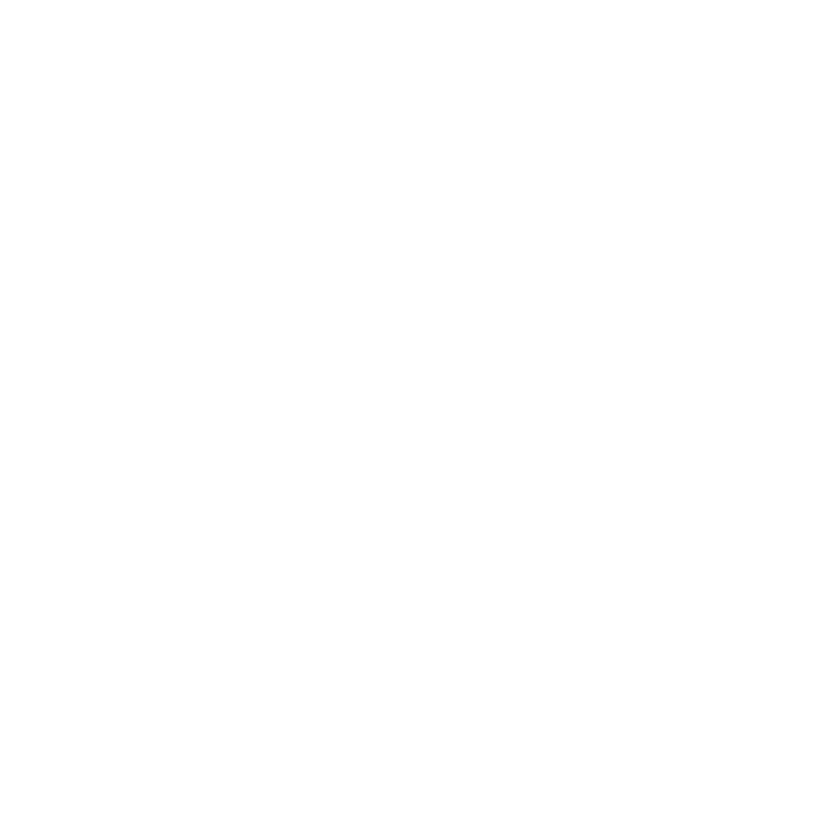

In [84]:
P

In [31]:
  ucb_df <- as.data.frame(UCBAdmissions)
  ucb_df$Admit <- NULL
  ucb_df$Highlight <- FALSE
  ucb_df$Highlight[ucb_df$Gender=='Female' & ucb_df$Dept %in% c('A','D')] <- TRUE

In [32]:
ucb_lodes <- ggalluvial::to_lodes_form(ucb_df, axes = 1:2, id = "cohort")

In [35]:
ucb_lodes

Freq,Highlight,cohort,x,stratum
<dbl>,<lgl>,<int>,<fct>,<fct>
512,FALSE,1,Gender,Male
313,FALSE,2,Gender,Male
89,TRUE,3,Gender,Female
19,TRUE,4,Gender,Female
353,FALSE,5,Gender,Male
207,FALSE,6,Gender,Male
17,FALSE,7,Gender,Female
8,FALSE,8,Gender,Female
120,FALSE,9,Gender,Male


In [33]:

  
  
  col_vector <- RColorBrewer::brewer.pal(9, 'Set1')
  all_colors <- grDevices::colorRampPalette(col_vector)
  
  plot_palette <- c(col_vector[1:length(levels(ucb_df$Gender))], col_vector[1:length(levels(ucb_df$Dept))])
  plot_palette <- stats::setNames(plot_palette, c(levels(ucb_df$Gender), levels(ucb_df$Dept)))
  
  P <- ggplot2::ggplot(ucb_lodes, ggplot2::aes(x = x, stratum = stratum, y = Freq)) +
    ggplot2::scale_x_discrete(expand = c(.1, .1)) +
    ggplot2::scale_fill_manual(values=plot_palette) +
    ggalluvial::stat_stratum(geom = "stratum", alpha = .5, ggplot2::aes(fill = stratum)) +
    ggalluvial::stat_stratum(geom = "text", ggplot2::aes(label = stratum), size = 3) +
    ggalluvial::geom_flow(ggplot2::aes(alluvium = cohort, fill = stratum)) +
    ggplot2::ggtitle("test with highlights - 1") +
    ggplot2::scale_y_continuous(name="Freq") +
    ggplot2::theme_light() +
    ggplot2::theme(plot.title=ggplot2::element_text(face="bold",size=20),
                   axis.text.x=ggplot2::element_text(size=16),
                   axis.text.y=ggplot2::element_text(size=8),
                   axis.title.x=ggplot2::element_blank(),
                   axis.title.y=ggplot2::element_text(size=16),
                   legend.position="none")


Warning message:
“`spread_()` was deprecated in tidyr 1.2.0.
Please use `spread()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”
Warning message:
“The `.dots` argument of `group_by()` is deprecated as of dplyr 1.0.0.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


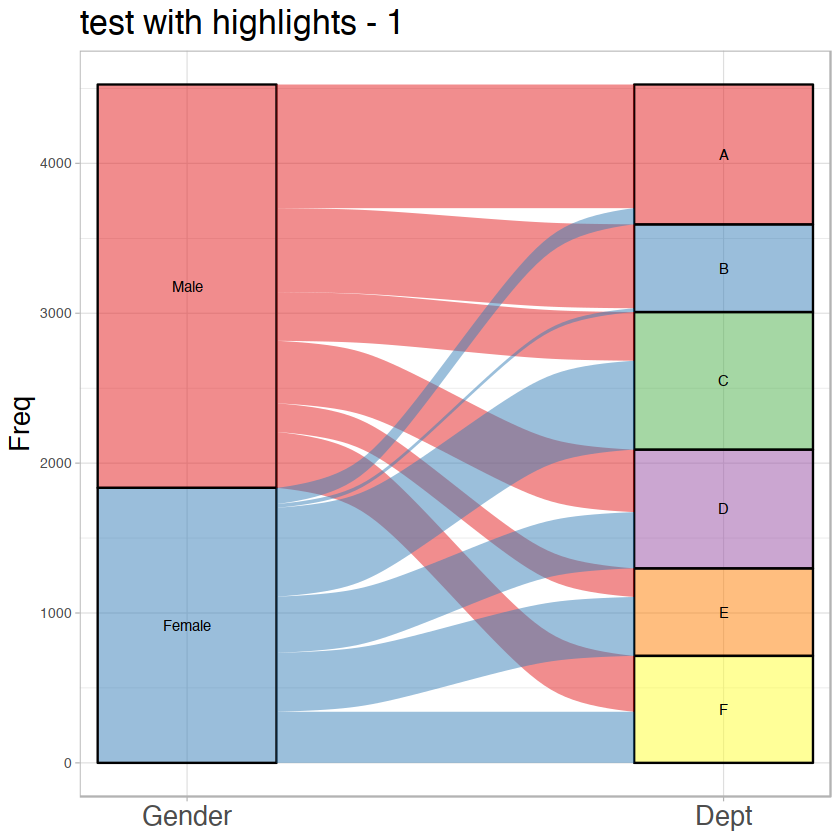

In [34]:
P

In [ ]:
plot_palette <- stats::setNames(rep("grey80",length(plot_palette)), names(plot_palette))
  high_colors <- data.frame(ID=c('Female','A','D'), color=c('black','red','blue'))
  high_colors <- high_colors[match(names(plot_palette)[names(plot_palette) %in% high_colors$ID], high_colors$ID),]
  plot_palette[names(plot_palette) %in% high_colors$ID] <- high_colors$color
  
  P <- ggplot2::ggplot(ucb_lodes, ggplot2::aes(x = x, stratum = stratum, y = Freq)) +
    ggplot2::scale_x_discrete(expand = c(.1, .1)) +
    ggplot2::scale_fill_manual(values=plot_palette) +
    ggalluvial::stat_stratum(geom = "stratum", alpha = .5, ggplot2::aes(fill = stratum)) +
    ggalluvial::stat_stratum(geom = "text", ggplot2::aes(label = stratum), size = 3) +
    ggalluvial::geom_flow(ggplot2::aes(alluvium = cohort, fill = stratum)) +
    ggplot2::ggtitle("test with highlights - 2") +
    ggplot2::scale_y_continuous(name="Freq") +
    ggplot2::theme_light() +
    ggplot2::theme(plot.title=ggplot2::element_text(face="bold",size=20),
                   axis.text.x=ggplot2::element_text(size=16),
                   axis.text.y=ggplot2::element_text(size=8),
                   axis.title.x=ggplot2::element_blank(),
                   axis.title.y=ggplot2::element_text(size=16),
                   legend.position="none")


In [124]:
p <- ggplot(data = alluvialdf[ !duplicated(alluvialdf$TcRb),], aes(x = Sample, y = Freq, 
                                   stratum = TcRb, alluvium = xx))
myp <- p + 
geom_stratum(aes(fill = TcRb), decreasing = FALSE, stat = "alluvium") +
geom_alluvium(aes(fill = xx),decreasing = FALSE) + 

scale_fill_manual(breaks = names(recurringmotifColors_all[recurringmotifColors_all != "white"]), values = recurringmotifColors_all) 


In [49]:
alluvialdf[2,"TcRb"] <- "CASSVALASGANVLTF"
alluvialdf[2,"xx"] <- "SVAL:CASSVALASGANVLTF"

In [48]:
alluvialdf

,xx,index,pattern,Fisher_score,number_subject,number_unique_cdr3,final_score,hla_score,vb_score,expansion_score,length_score,cluster_size_score,type,ulTcRb,TcRb,V,J,TcRa,Sample,Freq
,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,SVAL:CASSVALASGANVLTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSVaLASGANVLTF,CASSVALASGANVLTF,TRBV9,TRBJ2-6,CAGAGGGGFKTIF,02/0152:MegaIL2,2
2,SVAL:CASSVALSNYGYTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValsNYGYTF,CASSVALASGANVLTF,TRBV9,TRBJ1-2,CAVVASGGSYIPTF,01/1013:MtbLys,2
3,SVAL:CASSVALYGQSVTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValyGQsvTF,CASSVALYGQSVTF,TRBV9,TRBJ1-2,CAAFSGTYKYIF,09/0328:MtbLys,1
4,SVAL:CASSVALLAGTQYF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValLAGTQYF,CASSVALLAGTQYF,TRBV9,TRBJ2-3,CAGPGGTSYGKLTF,09/0671:MtbLys,1
5,SVAL:CASSVALGAGGGYTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValgAGGGYTF,CASSVALGAGGGYTF,TRBV9,TRBJ1-2,CAGPSGGSYIPTF,09/0328:MtbLys,1
6,SVAL:CASSVALLGETQYF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSVallgETQYF,CASSVALLGETQYF,TRBV9,TRBJ2-5,CAGAPTGNQFYF,09/0772:MtbLys,1
7,SVAL:CASSVALLGETQYF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSVallgETQYF,CASSVALLGETQYF,TRBV9,TRBJ2-5,CAGTGGTSYGKLTF,09/0531:MtbLys,1
8,SVAL:CASSVALMGGELFF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSValmgGELFF,CASSVALMGGELFF,TRBV9,TRBJ2-2,CASLSGTYKYIF,09/0018:MegaIFNg,1
9,SVAL:CASSVALAGANGYTF,1,SVAL,4.4e-19,10,16,5.7e-13,0.0004,0.001,0.450,0.037,8.6e-05,motif-SVAL,CASSVaLAGanGYTF,CASSVALAGANGYTF,TRBV9,TRBJ1-2,CAGPVQGGNKLVF,01/0943:MtbLys,1


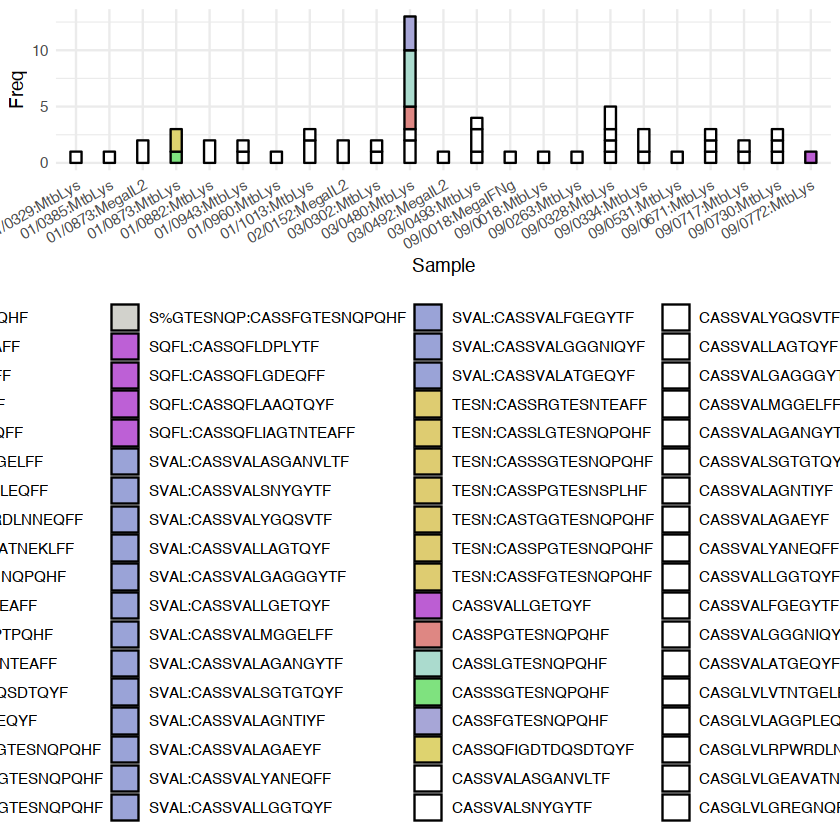

In [163]:
ggplot(data = alluvialdf[ !duplicated(alluvialdf$TcRb),], aes(x = Sample, y = Freq, 
                                   stratum = TcRb, alluvium = xx)) +
  geom_alluvium(aes(fill=xx)) +
  geom_stratum(aes(fill=TcRb)) +

  theme_minimal() + theme(legend.position = "bottom", axis.text.x = element_text(angle = 30, hjust = 1)) +
scale_fill_manual(
                  values = recurringmotifColors_all) 

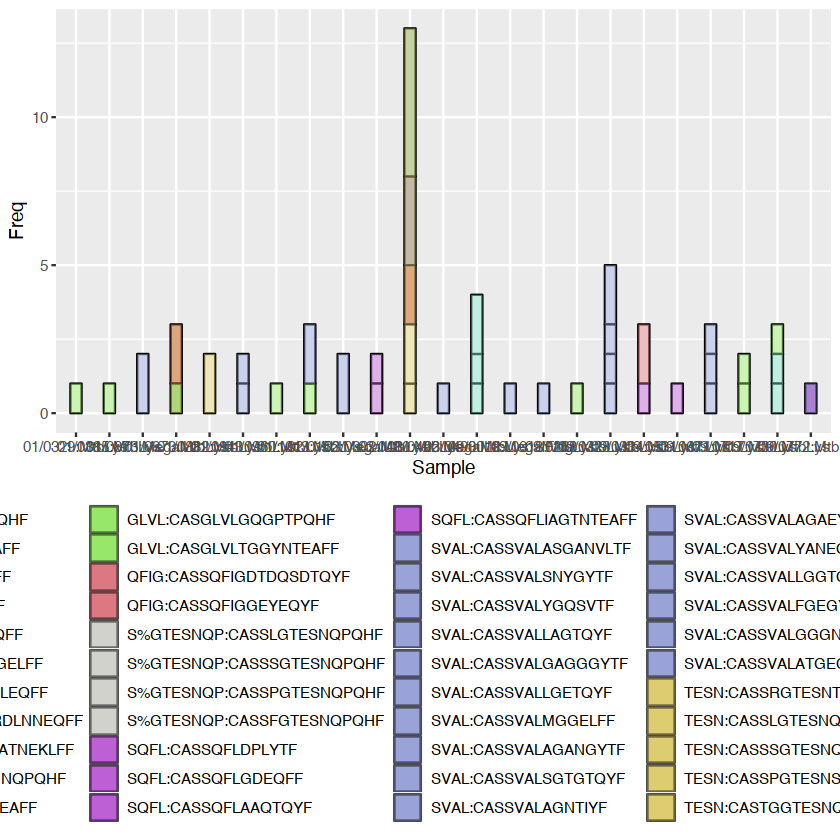

In [125]:
myp + theme(legend.position = "bottom")

In [137]:
tmp <- ggalluvial::to_lodes_form(alluvialdf[, c("xx", "TcRb", "Sample","Freq")], axes = 1:2, id = "id")

In [138]:
head(tmp)

,Sample,Freq,id,x,stratum
,<chr>,<dbl>,<int>,<fct>,<fct>
1,02/0152:MegaIL2,2,1,xx,SVAL:CASSVALASGANVLTF
2,01/1013:MtbLys,2,2,xx,SVAL:CASSVALSNYGYTF
3,09/0328:MtbLys,1,3,xx,SVAL:CASSVALYGQSVTF
4,09/0671:MtbLys,1,4,xx,SVAL:CASSVALLAGTQYF
5,09/0328:MtbLys,1,5,xx,SVAL:CASSVALGAGGGYTF
6,09/0772:MtbLys,1,6,xx,SVAL:CASSVALLGETQYF


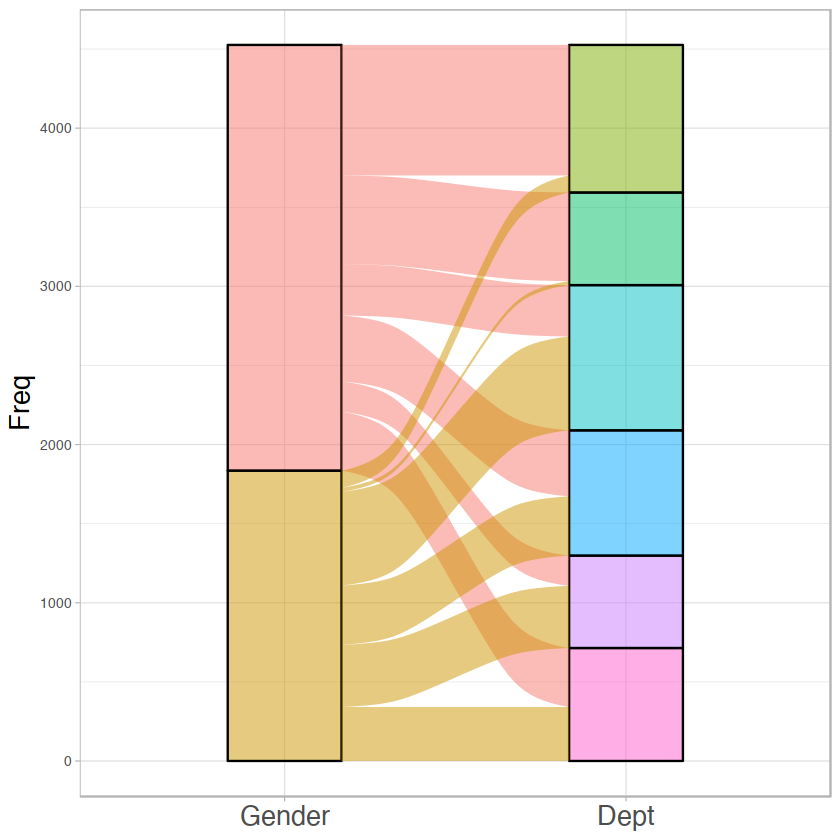

In [141]:
ggplot(ucb_lodes, ggplot2::aes(x = x, stratum = stratum, y = Freq)) +
 #   ggplot2::scale_fill_manual(values=plot_palette) +
    ggalluvial::stat_stratum(geom = "stratum", alpha = .5, ggplot2::aes(fill = stratum)) +
  #  ggalluvial::stat_stratum(geom = "text", ggplot2::aes(label = stratum), size = 3) +
    ggalluvial::geom_flow(ggplot2::aes(alluvium = cohort, fill = stratum)) +
    ggplot2::scale_y_continuous(name="Freq") +
    ggplot2::theme_light() +
    ggplot2::theme(plot.title=ggplot2::element_text(face="bold",size=20),
                   axis.text.x=ggplot2::element_text(size=16),
                   axis.text.y=ggplot2::element_text(size=8),
                   axis.title.x=ggplot2::element_blank(),
                   axis.title.y=ggplot2::element_text(size=16),
                   legend.position="none")

ERROR while rich displaying an object: Error in f(...): Data is not in a recognized alluvial form (see `help('alluvial-data')` for details).

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr

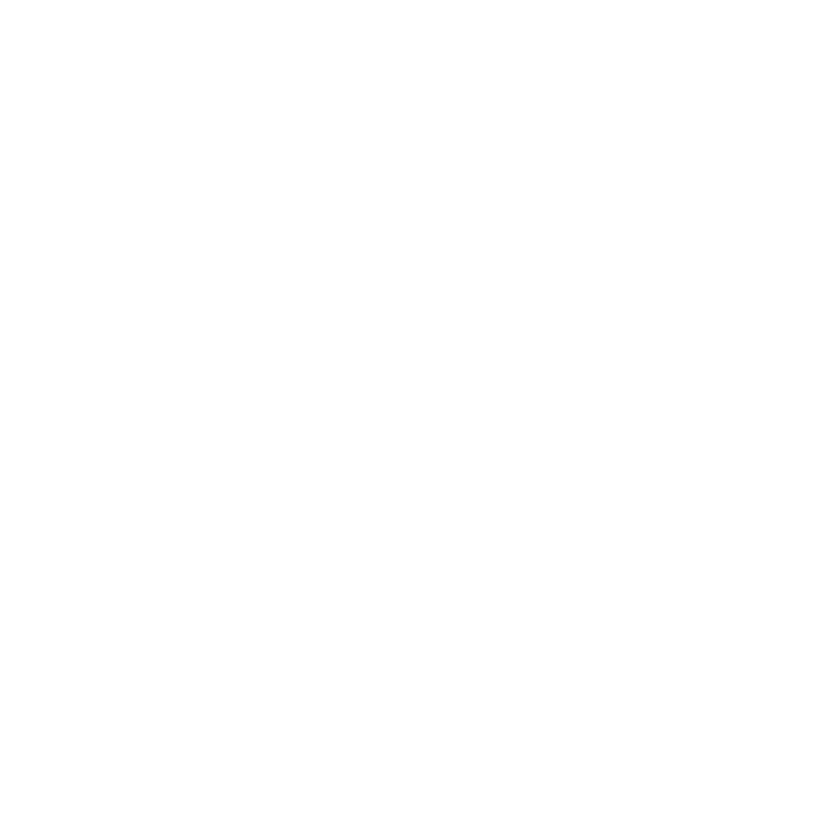

In [215]:
p <- ggplot(data = alluvialdf, aes(x = Sample, y = Freq, 
        fill = pattern, stratum = TcRb, alluvium = pattern))
    myp <- p + geom_alluvium(decreasing = FALSE) + 
geom_stratum(decreasing = FALSE, stat = "alluvium") + 
scale_fill_manual(breaks = names(myColors[myColors != "white"]), values = myColors) + 
theme(axis.title.y = element_text(size = 50), 
axis.title.x = element_blank(), axis.line = element_line(color = "black"), 
      axis.text = element_text(size = 50), axis.text.x = element_text(angle = 45, 
                                                                      hjust = 1), plot.title = element_text(size = 50, 
                                                                                                            hjust = 0.5)) + theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), panel.background = element_rect(fill = "transparent", 
            colour = NA), legend.key = element_rect(fill = "white", 
            colour = "white"), legend.position = "none", plot.margin = unit(c(0.2, 
            0, 0, 0), "cm"))# + labs(y = countfrac) + labs(title = plottitle)
myp

In [140]:
colnames(alluvialdf)[3] <- "xxx"

In [151]:
tail(alluvialdf)

,Sample,TcRb,xxx
,<chr>,<chr>,<dbl>
180,01/0329:MtbLys,CASSQFIGDTDQSDTQYF,0
181,01/0882:MtbLys,CASSQFIGDTDQSDTQYF,0
182,03/0480:MtbLys,CASSQFIGDTDQSDTQYF,0
183,03/0493:MtbLys,CASSQFIGDTDQSDTQYF,0
184,03/0302:MtbLys,CASSQFIGDTDQSDTQYF,0
185,09/0334:MtbLys,CASSQFIGDTDQSDTQYF,0


In [142]:
length(CDR3_fraction$samplename)

[1] 923

In [143]:
head(CDR3_fraction)

,samplename,nSeqCDR3,cloneFraction,cloneCount
,<chr>,<chr>,<dbl>,<dbl>
3,CHP_375-01-PBMC-DNA,TGTGCCAGCAGTGAACTAGCGGGGGGGTACAATGAGCAGTTCTTC,0.2162162,8
5,CHP_375-01-PBMC-DNA,TGTGCCAGTAGTCTTCACGGGGACAGGGGATTTTATGGCTACACCTTC,0.1351351,5
6,CHP_375-01-PBMC-DNA,TGTGCCAGCAGTGACTCTAGCGGGGGGGCCAATGAGCAGTTCTTC,0.1351351,5
7,CHP_375-01-PBMC-DNA,TGTGCCAGCAGCCACAGGGGGTGGGTCAATCAGCCCCAGCATTTT,0.1351351,5
8,CHP_375-01-PBMC-DNA,TGTGCCAGCAGCTTAGGGGGGTACCAAGAGACCCAGTACTTC,0.1351351,5
9,CHP_375-01-PBMC-DNA,TGTGCCAGCAATCCGGGGCCGGGGGTTAACACTGAAGCTTTCTTT,0.1081081,4


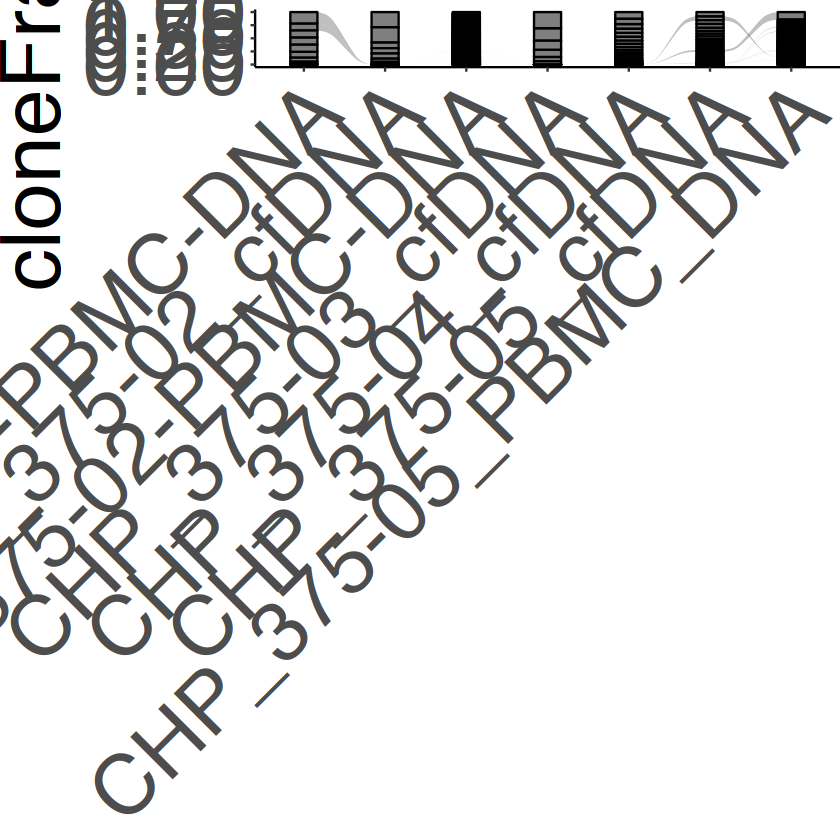

In [144]:
p <- ggplot(as.data.frame(CDR3_fraction), aes(x = samplename, y = cloneFraction, 
        fill = nSeqCDR3, stratum = nSeqCDR3, alluvium = nSeqCDR3, 
        label = nSeqCDR3))
    myp <- p + geom_alluvium(decreasing = FALSE) + geom_stratum(decreasing = FALSE, 
        stat = "alluvium") + scale_fill_manual(breaks = names(myColors[myColors != 
        "white"]), values = myColors) + theme(axis.title.y = element_text(size = 50), 
        axis.title.x = element_blank(), axis.line = element_line(color = "black"), 
        axis.text = element_text(size = 50), axis.text.x = element_text(angle = 45, 
            hjust = 1), plot.title = element_text(size = 50, 
            hjust = 0.5)) + theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), panel.background = element_rect(fill = "transparent", 
            colour = NA), legend.key = element_rect(fill = "white", 
            colour = "white"), legend.position = "none", plot.margin = unit(c(0.2, 
            0, 0, 0), "cm")) 

    print(myp)